### Goal of this notebook:
Investigate the differences between the BookCrossings and MovieLens ratings datasets to determine what is causing the poor training of collaborative filter models on the former.

In [28]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division, print_function
from collections import Counter
import networkx as nx
import random

### Read in both datasets

In [4]:
ml_path = "data/ml-small/"
bx_path = "data/book-crossings/"

In [5]:
ml_ratings = pd.read_csv(ml_path+'ratings.csv')
ml_ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
bx_ratings = pd.read_csv(bx_path+"BX-Book-Ratings.csv", delimiter=';')
bx_ratings = bx_ratings[bx_ratings["Book-Rating"] != 0]
bx_ratings.columns = ['userId', 'bookId', 'rating']
bx_ratings.head()

,userId,bookId,rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6


### Compare global statistics
* Raw number of valid datapoints
* Number of unique users, items
* Frequency distributions of users, items
* Distributions of ratings

In [7]:
# compare total dataset size
print(len(ml_ratings))
print(len(bx_ratings))

100004
433671


In [8]:
ml_users = ml_ratings.userId.unique()
ml_items = ml_ratings.movieId.unique()
n_ml_users = ml_ratings.userId.nunique()
n_ml_items = ml_ratings.movieId.nunique()
print("%d users and %d movies" %(n_ml_users, n_ml_items))
print("Average of %2.1f ratings per user." % (len(ml_ratings) / n_ml_users))
print("Average of %2.1f ratings per movie." % (len(ml_ratings) / n_ml_items))

671 users and 9066 movies
Average of 149.0 ratings per user.
Average of 11.0 ratings per movie.


In [9]:
bx_users = bx_ratings.userId.unique()
bx_items = bx_ratings.bookId.unique()
n_bx_users = bx_ratings.userId.nunique()
n_bx_items = bx_ratings.bookId.nunique()
print("%d users and %d books" %(n_bx_users, n_bx_items))
print("Average of %2.1f ratings per user." % (len(bx_ratings) / n_bx_users))
print("Average of %2.1f ratings per book." % (len(bx_ratings) / n_bx_items))

77805 users and 185973 books
Average of 5.6 ratings per user.
Average of 2.3 ratings per book.


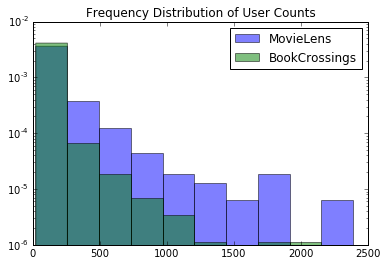

In [10]:
# get freq dists of users, items
ml_user_counts = Counter(ml_ratings.userId)
ml_counts, ml_bins, _ = plt.hist(ml_user_counts.values(), log=True, alpha=0.5, normed=True, label='MovieLens')
bx_user_counts = Counter(bx_ratings.userId)
plt.hist(bx_user_counts.values(), bins = ml_bins, alpha=0.5, log=True, normed=True, label='BookCrossings')
plt.legend()
plt.title('Frequency Distribution of User Counts')

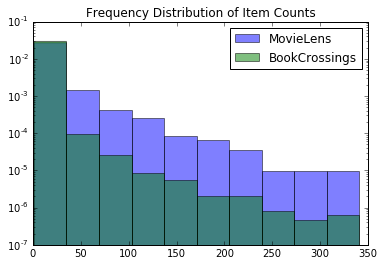

In [11]:
ml_item_counts = Counter(ml_ratings.movieId)
ml_counts, ml_bins, _ = plt.hist(ml_item_counts.values(), log=True, alpha=0.5, normed=True, label='MovieLens')
bx_item_counts = Counter(bx_ratings.bookId)
plt.hist(bx_item_counts.values(), bins = ml_bins, alpha=0.5, log=True, normed=True, label='BookCrossings')
plt.legend()
plt.title('Frequency Distribution of Item Counts')

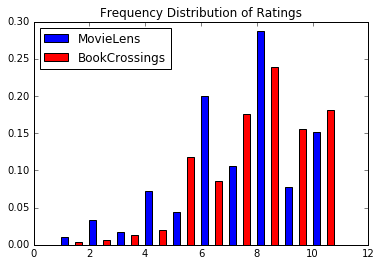

In [12]:
# freq dists of ratings
ml_rating_counter = Counter(ml_ratings.rating)
ml_rating_scores = 2*np.array(ml_rating_counter.keys())
ml_rating_counts = np.array(ml_rating_counter.values()) / np.sum(ml_rating_counter.values())
bx_rating_counter = Counter(bx_ratings.rating)
bx_rating_scores = np.array(bx_rating_counter.keys()) + 0.5
bx_rating_counts = np.array(bx_rating_counter.values()) / np.sum(bx_rating_counter.values())
plt.bar(ml_rating_scores, ml_rating_counts,
        width=0.25, label='MovieLens', color='blue')
plt.bar(bx_rating_scores, bx_rating_counts,
        width=0.25, label='BookCrossings', color='red')
plt.legend(loc='upper left')
plt.title('Frequency Distribution of Ratings')

### Compare ratings graph structures
* Clique sizes?
* Connected Components?

In [13]:
mlG = nx.Graph()

for user in ml_ratings.userId:
    mlG.add_node("u%d" % user)
for item in ml_ratings.movieId:
    mlG.add_node("i%d" % item)
for row in ml_ratings.itertuples():
    mlG.add_edge("u%d"%row[1], "i%d"%row[2])

In [14]:
print(len(list(nx.connected_components(mlG))))

1


In [17]:
bxG = nx.Graph()

for user in bx_ratings.userId:
    bxG.add_node("u%d" % user)
for item in bx_ratings.bookId:
    bxG.add_node("i%s" % item)
for row in bx_ratings.itertuples():
    bxG.add_edge("u%d"%row[1], "i%s"%row[2])

In [ ]:
print(len(list(nx.connected_components(bxG))))
bx_conn = list(nx.connected_components(bxG))
bx_conn.sort(key=len, reverse=True)
bx_conn_largest = bx_conn[0]

### Restrict BookCrossings to the largest connected component

In [62]:
bx_lcc_users = [int(n[1:]) for n in bx_conn_largest if n[0] == 'u']
#print(bx_lcc_users[:10])
print("There are %d users in the largest component." % len(bx_lcc_users))
print("This is %2.1f%% of all users." % (100 * len(bx_lcc_users) / n_bx_users))

There are 61958 users in the largest component.
This is 79.6% of all users.


In [63]:
bx_lcc_items = [n for n in bx_conn_largest if n[0] == 'i']
#print(bx_lcc_items[:10])
print("There are %d items in the largest component." %len(bx_lcc_items))
print("This is %2.1f%% of all items." % (100 * len(bx_lcc_items) / n_bx_items))

There are 167192 items in the largest component.
This is 89.9% of all items.


In [64]:
bx_ratings_lcc = bx_ratings[bx_ratings.userId.isin(bx_lcc_users)]
print("%2.1f%% of all ratings are in the largest component." % 
      (100 * len(bx_ratings_lcc) / len(bx_ratings)))

95.4% of all ratings are in the largest component.


It's a little hard to believe that my performance is getting smashed by 5% of the entries...

### Retry collaborative filtering on the connected subset